# 23Na-3He-ES Analysis --Kaixin, updated on 03/02/2022

## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats,interpolate
import os
from KaixinSpecTools import *


## Set file path

In [2]:
path_fresco='/home/kaixin/Documents/23NaHe3d_Analysis/' # directory to run fresco and generate fort.201, fort.202 files
path_specdata=path_fresco+'/SpecData' # directory where the datafiles are stored
path_fresco_input=path_fresco+'/FrescoInputFiles' # directory for fresco input files
path_fresco_data=path_fresco+'/FrescoInputData' # directory for yield data used for fitting optical model parameters in fresco input. Not using now.

## Define useful constants and functions

In [3]:
Ep=21
m_3He=3.01602932008
m_23Na=22.98976928197
# From the AME 2012 atomic mass evaluation 

def angle_lab_to_CM(theta_lab,gamma):
    rad=theta_lab*np.pi/180
    theta_CM=np.arccos(-gamma*np.sin(rad)**2+np.cos(rad)*np.sqrt(1-gamma**2*np.sin(rad)**2))
    theta_CM=theta_CM*180/np.pi
    return theta_CM
def layout(l1,l2):
    for i in range(0,len(l1)):
        print(l1[i],'\t',l2[i])
def weighted_average(l1,l2):
    return sum(l1*l2) / sum(l2)
def makefigure(title,xlabel,ylabel):
    plt.figure(figsize=(9.5, 6.5))
    plt.rcParams['font.size'] = '16'
    plt.title(title)
    plt.xlabel(xlabel, fontsize=20.0)
    plt.ylabel(ylabel, fontsize=20.0)
def read_cross(filename):
    cross = pd.read_csv(filename, sep='\s+', skiprows=10, header=None)
    theta = cross[cross.columns[0]].tolist()[:-1]
    sigma = cross[cross.columns[1]].tolist()[:-1]
    theta=[float(x) for x in theta]
    sigma=[float(x) for x in sigma]
    return [theta, sigma]
def filerun(filepath):
    command = 'fresco' + '<' + filepath + '> /dev/null'
    os.system(command)
    print(command)

## Import data for elastic scattering (ES) and silicon detector

### Elastic scattering data

In [4]:
os.chdir(path_specdata)
df_es=pd.read_csv(path_specdata+'/ES.txt',sep='\t')
df_es.style

,run#,Angle_LAB,Centroid,+/-,Area,+/-.1,BCI_Summed,LiveTimeRatio,(BCI*LTR)_Summed
0,109,15,1596.370000,0.200000,45305.900000,1147.290000,261418,0.944119,246809.597600
1,110,20,1544.520000,0.151037,5753.350000,125.787000,254626,0.984811,250758.370900
2,111,25,1471.970000,0.102670,1942.260000,37.155300,291104,0.993304,289154.860400
3,112-113,30,1375.630000,0.138720,6459.280000,87.038500,1780977,0.967280,1722704.257000
4,114-115,35,1269.140000,0.097212,7081.770000,116.414000,1789879,0.959048,1716579.498000
5,116,40,1145.180000,0.186093,1708.080000,50.460800,2001086,0.984266,1969601.504000
6,118-120,45,2193.820000,0.168256,3345.500000,93.685500,5836894,0.981952,5731552.088000
7,121,50,2038.000000,0.218201,1117.280000,41.053000,1871247,0.980538,1834828.107000
8,122,55,1865.420000,0.229584,906.382000,29.930900,3804344,0.978250,3721599.571000
9,123,59,1718.930000,0.364018,362.718000,18.226100,6297424,0.983354,6192595.284000


### Si detector data for ES

In [5]:
df_es_si=pd.read_csv(path_specdata+'/'+'Si_ES.txt',sep='\t')
df_es_si.style

,run#,Angle_LAB,Centroid,+/-,Area,+/-.1,BCI_Summed,LiveTimeRatio,(BCI*LTR)_Summed,Si Yield
0,109,15,2101.150000,0.421237,802.737000,33.343300,261418,0.944119,246809.597600,0.000000
1,110,20,2101.790000,0.456467,789.434000,38.971500,254626,0.984811,250758.370900,0.000000
2,111,25,2103.480000,0.309818,976.390000,33.211100,291104,0.993304,289154.860400,0.000000
3,112-113,30,2104.460000,0.224646,5442.240000,102.179000,1780977,0.967280,1722704.257000,0.000000
4,114-115,35,2103.540000,0.188037,6881.250000,144.795000,1789879,0.959048,1716579.498000,0.000000
5,116,40,2102.280000,0.206655,5803.450000,120.396000,2001086,0.984266,1969601.504000,0.000000
6,118-120,45,2100.350000,0.164515,21491.600000,348.561000,5836894,0.981952,5731552.088000,0.000000
7,121,50,2101.200000,0.203589,8369.760000,167.172000,1871247,0.980538,1834828.107000,0.000000
8,122,55,2101.440000,0.150834,16539.400000,252.778000,3804344,0.978250,3721599.571000,0.000000
9,123,59,2101.550000,0.154213,28279.800000,427.785000,6297424,0.983354,6192595.284000,0.000000


## Lab to CM angle transformation and yield correction

The angles are can be converted to CM frame with JRelKin. However, I put it here in python code to facilitate calculations. I derived an equation from the book $\textbf{Nuclear Physics of Stars}\space (2015)$ by Christian ILiadis:
$$\cos \theta_{lab}=\frac{\gamma+\cos \theta_{CM}}{\sqrt{1+\gamma^{2}+2 \gamma \cos \theta_{CM}}}$$


$$\Longrightarrow \cos\theta_{CM}=-\gamma\sin^2\theta_{lab}+\cos\theta_{lab}\sqrt{1-\gamma^2\sin^2\theta_{lab}}$$
$\space\gamma=m_{3He}/m_{23Na}$ for elastic scattering.

In [6]:
gamma=m_3He/m_23Na
Angle_CM=angle_lab_to_CM(df_es['Angle_LAB'],gamma)
Angle_LAB=df_es['Angle_LAB']
print('CM angles: ',[i for i in Angle_CM])

CM angles:  [16.945822830999674, 22.571704693672693, 28.178297820593805, 33.76101890119579, 39.31544490803795, 44.837345881362985, 50.3227177404472, 55.76781484705748, 61.169181948986726, 65.4566724254198]


Using eqn.(C.43) and (C.44) from the book, the frame correction for the yield would be: 
$$\frac{(d Y / d \Omega)_{\theta-CM}}{(d Y / d \Omega)_{\theta-Lab}}=\frac{d(\cos \theta_{Lab})}{d\left(\cos \theta_{CM}\right)}=\frac{\sqrt{1-\gamma^{2} \sin ^{2} \theta_{Lab}}}{\left(\gamma \cos \theta_{Lab}+\sqrt{1-\gamma^{2} \sin ^{2} \theta_{Lab}}\right)^{2}}$$

Here we apply the correction for the yield instead of cross section. Note that the silicon detector was placed at 45 degree in lab frame, never changed. For elastic scattering, $\gamma=\frac{m_a}{m_A}$

In [7]:
Angle_si=angle_lab_to_CM(45,m_3He/m_23Na)
print('CM angle for si detector: ',Angle_si)
frame_corr_es=np.sqrt(1-gamma**2*np.sin(Angle_CM*np.pi/180)**2)/(gamma*np.cos(Angle_CM*np.pi/180)+np.sqrt(1-gamma**2*np.sin(Angle_CM*np.pi/180)**2)**2)
frame_corr_si=np.sqrt(1-gamma**2*np.sin(Angle_si*np.pi/180)**2)/(gamma*np.cos(Angle_si*np.pi/180)+np.sqrt(1-gamma**2*np.sin(Angle_si*np.pi/180)**2)**2)
print(frame_corr_es,frame_corr_si)

CM angle for si detector:  50.3227177404472
0    0.889004
1    0.892836
2    0.897712
3    0.903590
4    0.910424
5    0.918154
6    0.926716
7    0.936032
8    0.946021
9    0.954435
Name: Angle_LAB, dtype: float64 0.926715679496491


My calculated CM-angles are the same as Caleb's up to four digits after the decimal point!

## Calcultions for yields and cross sections

### Yield

From Caleb's thesis p.132:
$$\frac{d Y}{d \Omega}=\frac{N_{R}}{N_{B} \Omega}$$
Where
$$N_R=\frac{A}{t_{live}}$$
$$ $$
$$N_B=\frac{BCI\times fullscale}{eq}$$
The geometric solid angles are $\Omega_{FP}=1.00(4)\space msr$ for the focal plane detector, and $\Omega_{Si}=4.23(4)\space msr$ for the silicon monitor detector. A is the peak area in the spectrum, 
$t_{live}$ is the livetime, the BCI full-scale was set to $10^{-10}$ C/pulse. $e$ is the elementary charge. The charge state of the beam: $q=+2$ for $^3 He$ beam in this experiment.
$$$$
We get the yield:
$$ $$
$$\left(\frac{d Y}{d \Omega}\right)_{es}=\frac{Aeq}{\Omega_{FP}\times BCI\times t_{live}\times fullscale}=\frac{A\times 1.6\times 10^{-19}\times 2}{1\times BCI\times t_{live}\times10^{-10}}=3.2\times 10^{-9}\times\frac{A}{BCI\times t_{live}}$$ $$$$
$$\left(\frac{d Y}{d \Omega}\right)_{Si}=\frac{Aeq}{\Omega_{Si}\times BCI\times t_{live}\times fullscale}=\frac{A\times 1.6\times 10^{-19}\times 2}{4.23\times BCI\times t_{live}\times10^{-10}}=7.57\times 10^{-10}\times\frac{A}{BCI\times t_{live}}$$
$$$$

ES yield in msr^-1: 

16.945822830999674 	 5.22211437476371e-07
22.571704693672693 	 6.555218714142232e-08
28.178297820593805 	 1.9295839399774178e-08
33.76101890119579 	 1.08416375388384e-08
39.31544490803795 	 1.201908556925465e-08
44.837345881362985 	 2.547977143045326e-09
50.3227177404472 	 1.7309530169304522e-09
55.76781484705748 	 1.8239271445584582e-09
61.169181948986726 	 7.372799741847318e-10
65.4566724254198 	 1.7889280808014502e-10

 Si yield in msr^-1: 

16.945822830999674 	 2.2816741793507336e-09
22.571704693672693 	 2.2085273299876034e-09
28.178297820593805 	 2.368837211438446e-09
33.76101890119579 	 2.216202057405329e-09
39.31544490803795 	 2.8121974214783314e-09
44.837345881362985 	 2.0670466138117097e-09
50.3227177404472 	 2.630503572243267e-09
55.76781484705748 	 3.2000739260510307e-09
61.169181948986726 	 3.117686900460052e-09
65.4566724254198 	 3.2036571071483294e-09


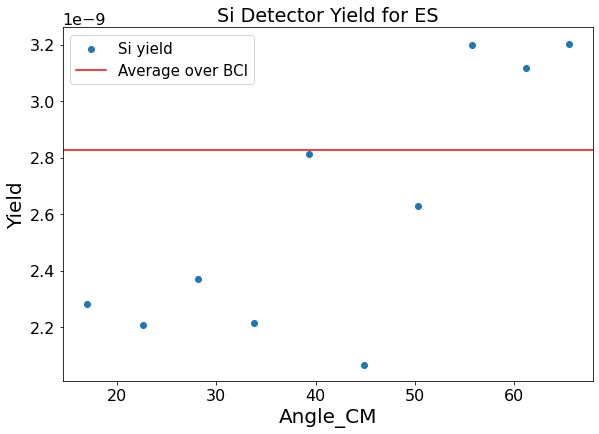

In [16]:

Yield_es=3.2*10**(-6)*df_es['Area']/df_es['(BCI*LTR)_Summed']*frame_corr_es
Yield_es_si=7.57*10**(-7)*df_es_si['Area']/df_es_si['(BCI*LTR)_Summed']*frame_corr_si
avg_Yield_es_si=weighted_average(Yield_es_si,df_es_si['(BCI*LTR)_Summed'])

print('ES yield in msr^-1: \n')
layout(Angle_CM,Yield_es)
print('\n','Si yield in msr^-1: \n')
layout(Angle_CM,Yield_es_si)

makefigure('Si Detector Yield for ES','Angle_CM','Yield')
plt.scatter(Angle_CM,Yield_es_si,label='Si yield')
# plt.axhline(y=np.average(Yield_es_si), color='orange', linestyle='-',label='Average')
plt.axhline(y=avg_Yield_es_si, color='r', linestyle='-',label='Average over BCI')
plt.legend(fontsize=15)
plt.show()

In [9]:
np.sqrt(np.sum(((Yield_es_si-avg_Yield_es_si)/avg_Yield_es_si)**2)/(len(Yield_es_si)-1))
np.sqrt(0.176552**2+0.1**2)

0.20290541812381452

In [10]:
np.sqrt(0.177**2+0.101**2+0.10**2)

0.2270022026324855

### Correct ES yield from Si detector data

Next we would like to normalize the ES yield with the monitor detector yield according to eqn.(6.15) on page 136 in Caleb's thesis:

$$\frac{d Y}{d \Omega}\left(\theta_{i}\right)=\left[\frac{d Y}{d \Omega}_{F P}\left(\theta_{i}\right) / \frac{d Y}{d \Omega}_{\text {Si}}\right]$$

The reasoning behind this is desctibed on page 131, sect 6.8 in Caleb's thesis.

Normalized Yield: 
16.945822830999674 	 228.87204588736242
22.571704693672693 	 29.681401833406458
28.178297820593805 	 8.14570089772316
33.76101890119579 	 4.891989655280576
39.31544490803795 	 4.273912449196541
44.837345881362985 	 1.2326655461082046
50.3227177404472 	 0.6580310459165478
55.76781484705748 	 0.569964065426835
61.169181948986726 	 0.23648300734622751
65.4566724254198 	 0.055840185792974215


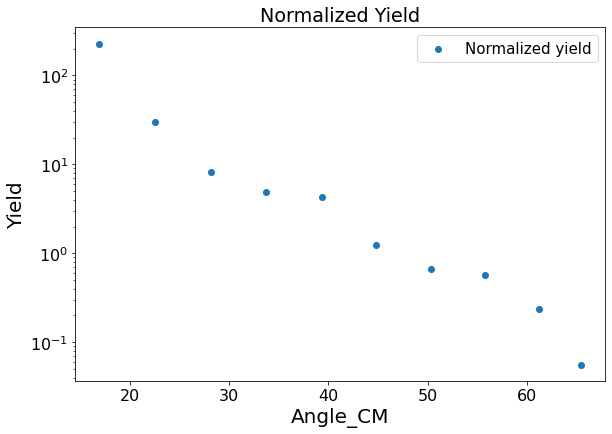

In [11]:
Yield_norm=Yield_es/Yield_es_si
print('Normalized Yield: ')
layout(Angle_CM,Yield_norm)
makefigure('Normalized Yield','Angle_CM','Yield')
plt.scatter(Angle_CM,Yield_norm,label='Normalized yield')
plt.legend(fontsize=15)
plt.yscale('log')
plt.show()

### Cross section

We can't get the cross section since we already divided the yield from si detector.

### Correction for Rutherfor cross section

The next thing is to further normalize the cross section with Rutherford cross section. Use the formula in 'Rutherford scattering' page in Wikipedia:
$$\frac{d \sigma}{d \Omega}=\left(\frac{Z_{1} Z_{2} \alpha(\hbar c)}{4 E_{\mathrm{K}} \sin ^{2} \frac{\Theta}{2}}\right)^{2}$$

16.945822830999674 	 0.07605338725776775
22.571704693672693 	 0.030697649740435776
28.178297820593805 	 0.020167692494713663
33.76101890119579 	 0.02452191849908222
39.31544490803795 	 0.03858992200555799
44.837345881362985 	 0.01838488265955239
50.3227177404472 	 0.015160534178205511
55.76781484705748 	 0.01922517963127992
61.169181948986726 	 0.011174911201760448
65.4566724254198 	 0.003363986494542829


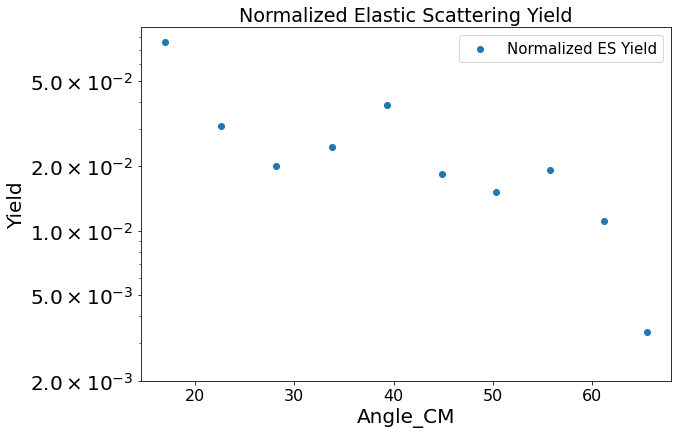

In [12]:
CrossSection_Rutherford=(2*11*(1/137)*197/4/21/np.sin(Angle_CM*np.pi/180/2)**2)**2*10 # 1 mb = 0.1 fm^2
Yield_norm=Yield_norm/CrossSection_Rutherford
layout(Angle_CM,Yield_norm)
makefigure('Normalized Elastic Scattering Yield','Angle_CM','Yield')
plt.scatter(Angle_CM,Yield_norm,label='Normalized ES Yield')
plt.legend(fontsize=15)
plt.yscale('log')
from num2tex import num2tex
ylabels=[]
for i in [5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1,5e-1]:
    if (i<0.1 and i>0.001):
        ylabels.append(i)
plt.yticks(ylabels,['$'+'{:.1e}'.format(num2tex(i))+'$'  for i in ylabels],fontsize=20)
plt.show()

## Run fresco for DWBA calculations

In [13]:
os.chdir(path_fresco)
fresco_input = path_fresco+'/FrescoInputFiles/23Na3Hed-es-11390.in'
#elastic_data_path = path_fresco_data+'/23Na-3He-3He copy.data'
#transfer_data_path = path_fresco_data+'23Na-3He-d-'+level+'.txt'
filerun(fresco_input)

fresco</home/kaixin/Documents/23NaHe3d_Analysis//FrescoInputFiles/23Na3Hed-es-11390.in> /dev/null


## Include uncertainties

The uncertaities are simply given by: $\sigma_{Y}=\sqrt{\sigma_{ES}^{2}+\sigma_{si}^{2}}$. Here I calculate the percentage instead of going through the normalizing process again.

In [14]:
Yield_uncertainty=np.sqrt((df_es['+/-.1']/df_es['Area'])**2+(df_es_si['+/-.1']/df_es_si['Area'])**2)

## Read fresco result and plot with scaled experiment data.

AttributeError: 'format_data' object has no attribute 'erry'

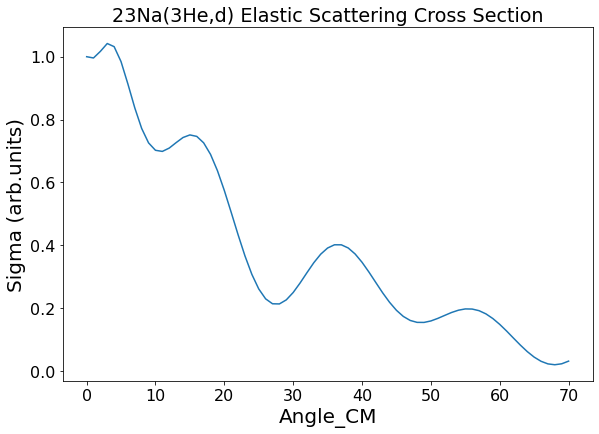

In [15]:

[theta_es, sigma_es] = read_cross('./fort.201')
spline_es = interpolate.UnivariateSpline(theta_es,sigma_es,s=0)
makefigure('23Na(3He,d) Elastic Scattering Cross Section','Angle_CM','Sigma (arb.units)')
plt.plot(theta_es, spline_es(theta_es), label='fresco-ES', lw=1.5)
fres=Minimizations.format_data(np.array(theta_es),np.array(sigma_es))
exp=Minimizations.format_data(np.array(Angle_CM),np.array(Yield_norm))
scale=Minimizations.ScaleMinimize(exp,fres)
plt.errorbar(Angle_CM, Yield_norm*scale, Yield_norm*Yield_uncertainty*scale, fmt='o',color='red',label='experiment-ES')
plt.yscale('log')
plt.legend(fontsize=15)
plt.tight_layout()

## Save yield data for MCMC calculations

In [ ]:
# ratio of transfer yield to si detector yield, we know it's proportional to the cross section.
d = {'Theta(CM)': Angle_CM, 'Sigma_Ratio': Yield_norm, 'uncertainty':Yield_norm*Yield_uncertainty}
df = pd.DataFrame(data=d)
df.to_csv(path_fresco_data+'/23Na-3He-ES.data',sep='\t',index=False)

# d = {'Theta(CM)': Angle_CM, 'Sigma_Ratio': Yield_norm*scale, 'uncertainty':Yield_norm*Yield_uncertainty*scale}
# df = pd.DataFrame(data=d)
# df.to_csv(path_fresco_data+'/23Na-3He-ES-normed.data',sep='\t',index=False)

In [ ]:
Yield_norm

In [ ]:
"""Copied from pfunk"""
class Angles():
    def __init__(self, theta, sigma):
        self.theta = np.asarray(theta, dtype='float64')
        self.sigma = np.asarray(sigma, dtype='float64')
class LineObject(Angles):
    def __init__(self, theta, sigma):
        Angles.__init__(self, theta, sigma)
class DataObject(Angles):
    def __init__(self, theta, sigma, erry):
        Angles.__init__(self, theta, sigma)
        self.erry = np.asarray(erry)
def read_cross(filename):
    cross = pd.read_csv(filename, sep='\s+', skiprows=10, header=None)
    theta = cross[cross.columns[0]].tolist()[:-1]
    sigma = cross[cross.columns[1]].tolist()[:-1]
    graphline = LineObject(theta, sigma)
    return graphline
def filerun(filepath):
    command = 'fresco' + '<' + filepath + '> /dev/null'
    os.system(command)
def read_data(filename, delim=None):
    if delim:
        data = pd.read_csv(filename, sep=delim)
    else:
        data = pd.read_csv(filename, sep='\s+')
    theta = data[data.columns[0]].tolist()
    sigma = data[data.columns[1]].tolist()
    try:
        erry = data[data.columns[2]]
        erry[erry == 0.0] = 1.e-6
        erry = erry.tolist()
    except IndexError:
        erry = None
    graphline = DataObject(theta, sigma, erry)
    return graphline
elastic_data_path = path_fresco+'/FrescoInputData/23Na-3He-ES.data'
expES=read_data(elastic_data_path)
plt.errorbar(expES.theta, expES.sigma, expES.erry, label='ES-Kaixin',fmt='o', color='r')
elastic_data_path = path_fresco+'/FrescoInputData/23Na-3He-ES-caleb.data'
expES2=read_data(elastic_data_path)
plt.errorbar(expES2.theta, expES2.sigma, expES2.erry, label='ES-caleb',fmt='o', color='b')
plt.yscale('log')
plt.title('Comparison of our ES data')
plt.legend(fontsize=15)
print('difference=',expES.sigma/expES2.sigma-1)
print('average: ',weighted_average(expES.sigma/expES2.sigma-1,df_es['(BCI*LTR)_Summed']))
plt.show()
plt.scatter(expES.theta,expES.sigma/expES2.sigma-1)
plt.title('percent error')
plt.axhline(y=np.sqrt(np.sum(expES.sigma/expES2.sigma-1)**2)/len(expES.sigma), color='r', linestyle='-',label='Root mean square')
plt.legend(fontsize=15)